### Importation

In [1]:
from pathlib import Path

import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

from PIL import Image
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input 
import tensorflow as tf

In [2]:
df = pd.read_csv("V2_Plant_Seedlings_DataFrame.csv")

In [3]:
# Importation des modèles
mnv2 = tf.keras.models.load_model("mnv2.h5")
unet = tf.keras.models.load_model("unet.h5")

In [4]:
label2class = {x : y for x, y in enumerate(sorted(df.species.unique()))}

### Définition des fonctions

In [5]:
def mnv2_preprocessing_with_tsegm(input_img, threshold =  118, preprocess_mnv2 = True):

    """
    Fonction de preprocessing comprenant la segmentation par seuillage colorimétrique 
    ainsi que les transformations géométriques d'ouverture/fermeture + un preprocessing propre à MobileNetV2
    Prend en entrée une image qui sera redimensionnée et renvoie le masque associé.
    
    L'argument preprocess_mnv2 peut être False afin de ne pas appliquer la normalisation propre au MobileNetV2.
    """
    
    # Etape 1: Segmentation simple par seuillage
    img_rgb = np.uint8(input_img)
    img_rgb = cv2.resize(img_rgb,(224,224))
    img_lab = cv2.cvtColor(img_rgb,cv2.COLOR_BGR2LAB)
    
    # Création du masque par seuillage
    _,mask = cv2.threshold(img_lab[:,:,1],threshold,255,cv2.THRESH_BINARY_INV)
    
    # Elimination du bruit par ouverture puis fermeture
    kernel = np.ones((2,2))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Application du masque à l'image
    masked_img = cv2.bitwise_and(img_rgb,img_rgb,mask=mask)

    # Etape 2: Preprocessing propre à MobileNetV2
    final_input = preprocess_input(masked_img)
    
    if preprocess_mnv2:
        return final_input  
    else:
        return masked_img

In [6]:
def load_preprocess_and_predict_img(model, img_filepath, IMG_SHAPE = 224, show = True):
    
    """
    Prend en argument un modèle et un chemin d'accès à une image pour afficher :
    l'image originelle, le masque prédit par le modèle, 
    l'image segmentée par ce dernier et l'image segmentée par seuil colorimétrique
    
    Renvoi l'image segmentée par prédiction du modèle.
    L'argument show permet d'afficher ou non les images.
    """

    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SHAPE, IMG_SHAPE])
    img = tf.cast(img, tf.float32)/255
    img = tf.expand_dims(img, 0)
    
    pred_mask = model.predict(img, verbose = 0).argmax(axis=-1)[0]
    pred_mask = np.uint8(pred_mask)
    
    kernel = np.ones((5,5))
    pred_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_OPEN, kernel)
    pred_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_CLOSE, kernel)
    
    pred_mask = pred_mask[..., tf.newaxis]

    img = img.numpy().squeeze()
    img_seg = cv2.bitwise_and(img, img, mask = pred_mask)
    
    img_seg2 = mnv2_preprocessing_with_tsegm(plt.imread(img_filepath)[:,:,:3], preprocess_mnv2 = False)
    
    if show:
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (13, 3), subplot_kw = dict(xticks=[], yticks=[]))
        ax1.imshow(img)
        ax1.set_title("Image")

        ax2.imshow(pred_mask)
        ax2.set_title("Predicted Mask")

        ax3.imshow(img_seg)
        ax3.set_title("Segmented Image")
        
        ax4.imshow(img_seg2)
        ax4.set_title("Segmented with color Image")
        plt.show()
    
    return img_seg

In [7]:
def invert_norm(img):
    
    """
    Retourne pour une image normalisée la même image codée entre 0 et 255.
    """
    
    invert_norm_img = cv2.normalize(img, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    invert_norm_img = invert_norm_img.astype(np.uint8)
    
    return invert_norm_img

In [11]:
def show_and_predict(img_filepath, segment_model = unet, class_model = mnv2):
    
    """
    Prend en argument un modèle et un chemin d'accès à une image pour afficher :
    l'image originelle, le masque prédit par le modèle, 
    l'image segmentée par ce dernier et l'image segmentée par seuil colorimétrique
    
    Renvoie les prédictions du modèle de classification sur l'image segmentée par seuillage 
    et sur celle segmentée par prédiction du modèle de Transfer Learning Unet
    """
    
    # Obtention de l'image segmentée par prédiction du modèle de Transfer Learning Unet
    # Affichage des images à comparer
    image_seg = load_preprocess_and_predict_img(segment_model, img_filepath)
    image_seg = image_seg[np.newaxis,...]
    
    # Prédiction de l'image segmentée par seuillage colorimétrique
    image = plt.imread(img_filepath).astype("float32")
    image = cv2.resize(image, (224,224))
    image = mnv2_preprocessing_with_tsegm(image)
    image = tf.expand_dims(image[:,:,:3], 0)
    
    pred1 = label2class[class_model.predict(image, verbose = 0).argmax(axis=-1)[0]]
    print("Classe prédite sur l'image segmentée par seuillage : ", pred1)
    
    # Prédiction de l'image segmentée par prédiction
    pred2 = label2class[class_model.predict(preprocess_input(invert_norm(image_seg)), verbose = 0).argmax(axis=-1)[0]] 
    print("Classe prédite sur l'image segmentée par Unet : ", pred2)

### Affichages & Prédictions

Sur une image

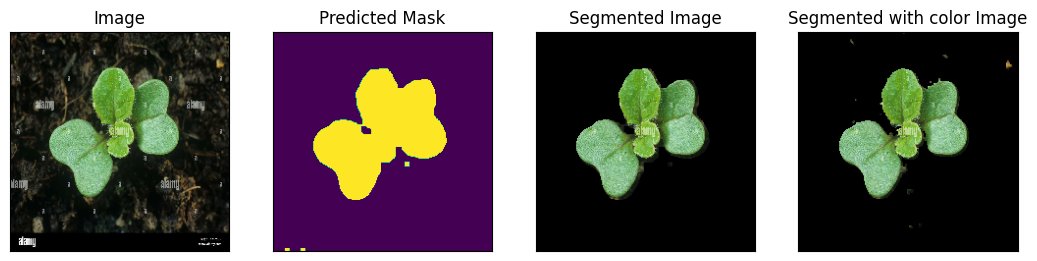

Classe prédite sur l'image segmentée par seuillage :  Charlock
Classe prédite sur l'image segmentée par Unet :  Charlock


In [13]:
show_and_predict("Charlock test.jpg")

Pour tout un dossier : 

Espèce :  Blackgrass


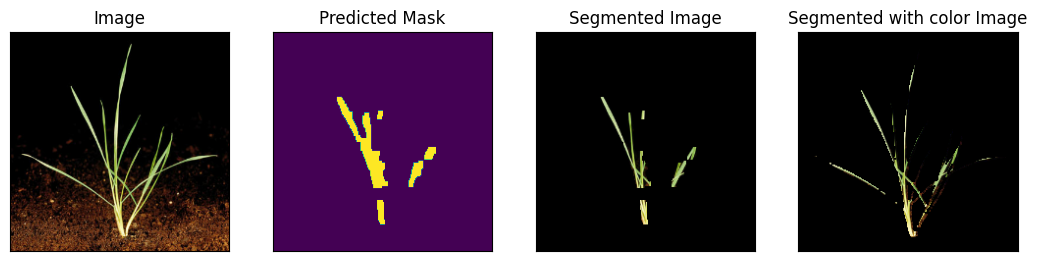

Classe prédite sur l'image segmentée par seuillage :  Black-grass
Classe prédite sur l'image segmentée par Unet :  Black-grass



Espèce :  Charlock


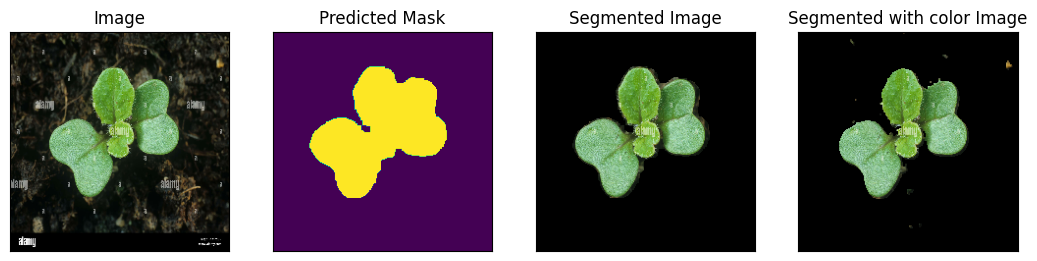

Classe prédite sur l'image segmentée par seuillage :  Charlock
Classe prédite sur l'image segmentée par Unet :  Charlock



Espèce :  Cleavers


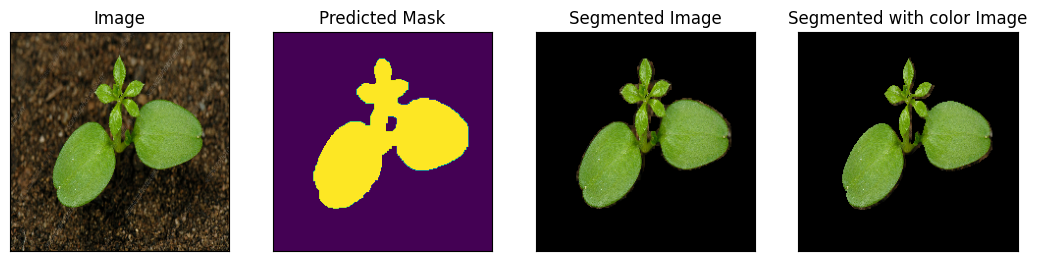

Classe prédite sur l'image segmentée par seuillage :  Shepherd's Purse
Classe prédite sur l'image segmentée par Unet :  Maize



Espèce :  Cleavers


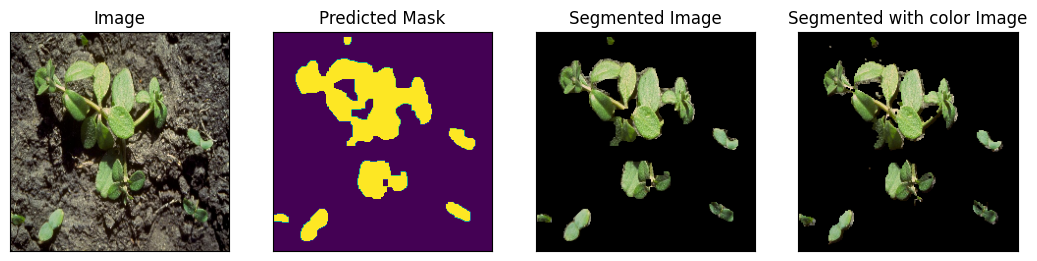

Classe prédite sur l'image segmentée par seuillage :  Scentless Mayweed
Classe prédite sur l'image segmentée par Unet :  Common wheat



Espèce :  Cleavers


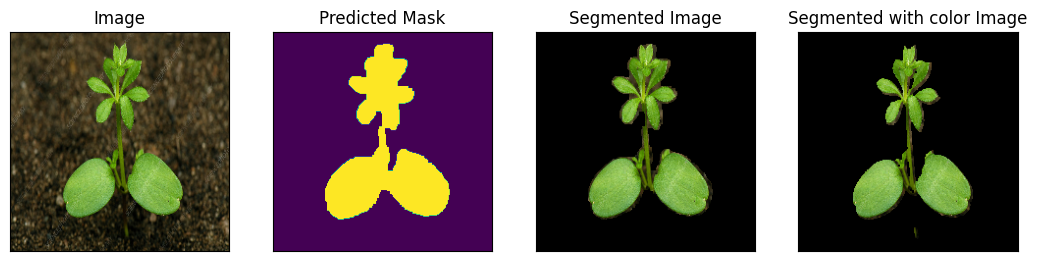

Classe prédite sur l'image segmentée par seuillage :  Scentless Mayweed
Classe prédite sur l'image segmentée par Unet :  Scentless Mayweed



Espèce :  Common chickweed


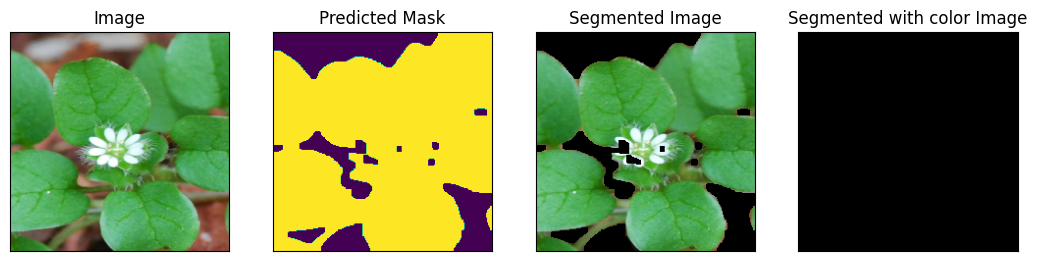

Classe prédite sur l'image segmentée par seuillage :  Common Chickweed
Classe prédite sur l'image segmentée par Unet :  Maize



Espèce :  Common chickweed


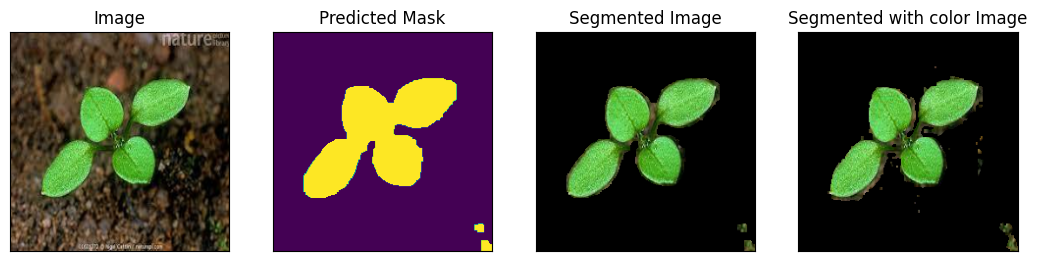

Classe prédite sur l'image segmentée par seuillage :  Common wheat
Classe prédite sur l'image segmentée par Unet :  Black-grass



Espèce :  Fat Hen


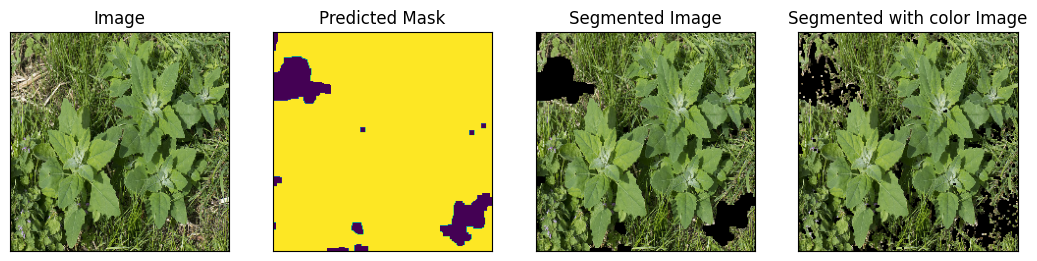

Classe prédite sur l'image segmentée par seuillage :  Black-grass
Classe prédite sur l'image segmentée par Unet :  Black-grass



Espèce :  Fat Hen


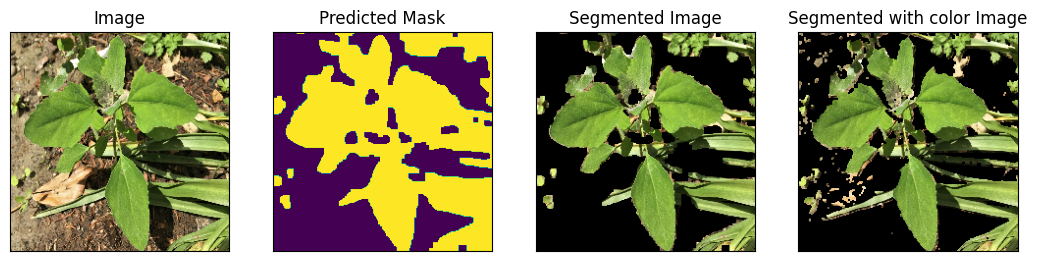

Classe prédite sur l'image segmentée par seuillage :  Maize
Classe prédite sur l'image segmentée par Unet :  Maize



Espèce :  Fat Hen


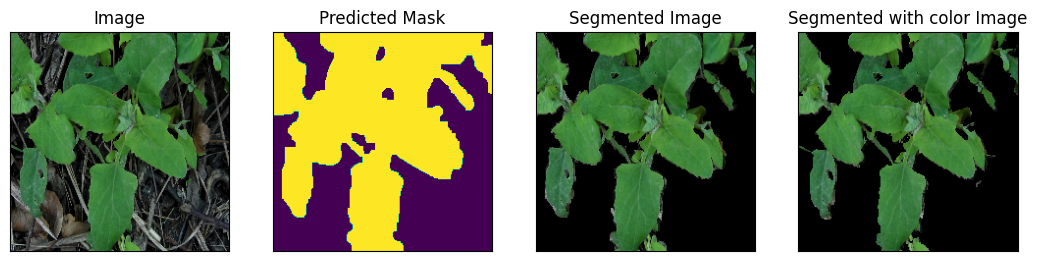

Classe prédite sur l'image segmentée par seuillage :  Maize
Classe prédite sur l'image segmentée par Unet :  Maize



Espèce :  Fat Hen


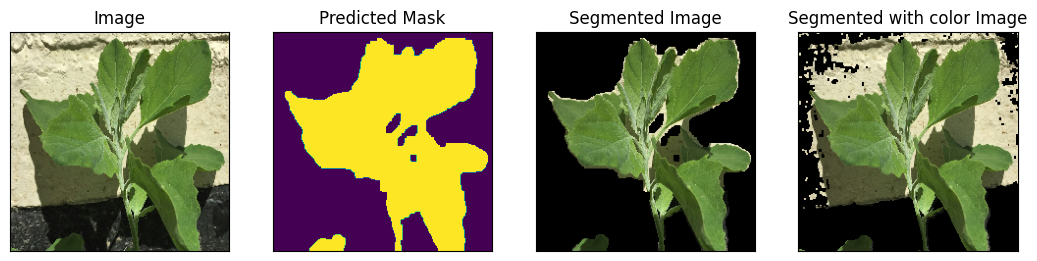

Classe prédite sur l'image segmentée par seuillage :  Maize
Classe prédite sur l'image segmentée par Unet :  Maize



Espèce :  Fat Hen


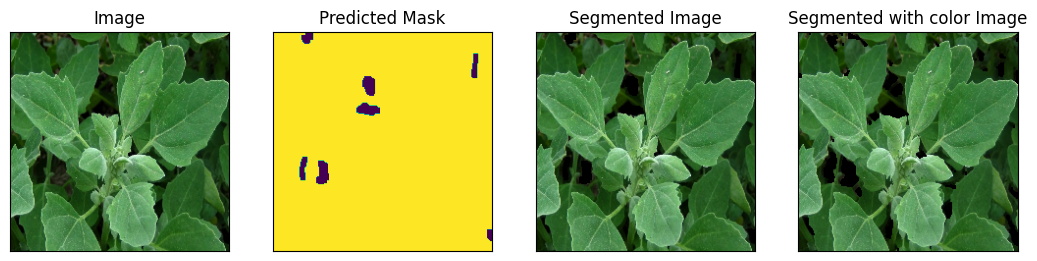

Classe prédite sur l'image segmentée par seuillage :  Charlock
Classe prédite sur l'image segmentée par Unet :  Charlock



Espèce :  Loose silky bent


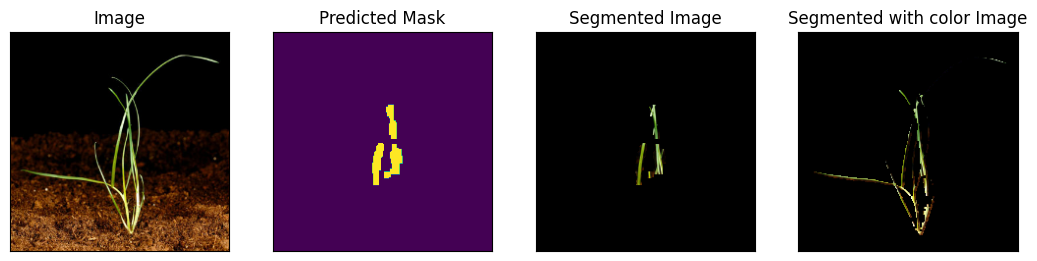

Classe prédite sur l'image segmentée par seuillage :  Black-grass
Classe prédite sur l'image segmentée par Unet :  Loose Silky-bent



Espèce :  Scentless mayweed 


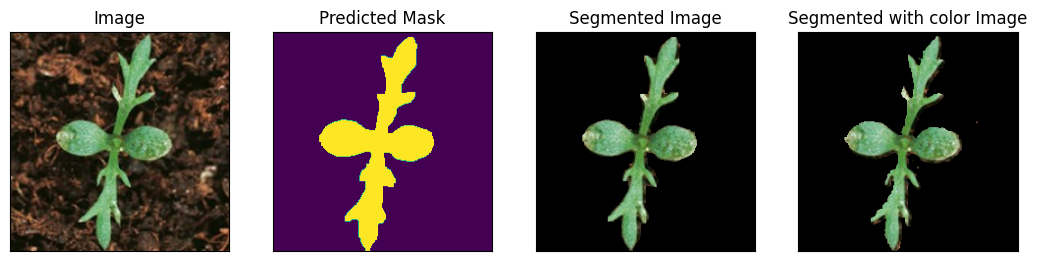

Classe prédite sur l'image segmentée par seuillage :  Scentless Mayweed
Classe prédite sur l'image segmentée par Unet :  Scentless Mayweed





In [14]:
FOLDER = "C:\Projet plantes\Plantes_à_prédire"

for plant_link in [FOLDER + "\\" + name for name in os.listdir(FOLDER)]:
    print("Espèce : ", plant_link[len(FOLDER)+1:-8])
    show_and_predict(plant_link)
    print("\n\n")

Concernant les performances du modèle de segmentation :
* Il apparaît de prime abord qu'il ait bien appris puisque les résultats de segmentation sont très satisfaisants.
* Pour l'oeil nu, la segmentation issue du masque prédit par unet paraît quelques fois même mieux réalisée qu'avec l'usage d'un simple seuillage colorimétrique(surtout lorsque les tons du fond  avoisinent le vert).
* Néanmoins les prédictions obtenues ne vont pas en ce sens puisque le classifieur est en moyenne plus performant sur les images segmentées grâce à la couleur. 

Notre modèle de classification est quant à lui en difficulté face à des images extérieures indépendament de la segmentation utilisée. Ce manque de robustesse peut s'expliquer par le manque de diversité des observations ayant servies à l'entraînement. Le modèle a en effet été entraîné sur un seul dataset comprenant des images de plantes provenant d'une source unique. Ainsi, une augmentation de données ne saurait pallier au fait que les images d'entraînement étaient toutes des pousses prises en vue du dessus.
Il est également à noter que les prédictions ne sont pas toujours les mêmes en fonction de la méthode de segmentation utilisée, ce qui traduit une fois de plus une certaine sensibilité du modèle.